# Machine Learning Example with Python on Kaggle Titanic Dataset
## Module Import

In [1]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import pickle
from itertools import combinations
# from sklearn.datasets import load_iris
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from ClassTuning import Tuning
import matplotlib.pyplot as plt
import seaborn as sns
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# from sklearn.preprocessing import StandardScaler
import ClassParamAnalysis as PMA
# from pathlib import Path


## Load Dataset

In [2]:
titanic = pd.read_csv('Titanic_train.csv', index_col=0)

titanic.drop(columns=['Cabin'], inplace=True)
titanic.dropna(inplace=True)

random_state = np.random.RandomState(42)

Y = titanic['Survived'].copy()
X = titanic.drop(columns=['Survived', 'Name', 'Ticket'])
X.dtypes

# X=pd.get_dummies(data=X, columns=['Sex', 'Embarked'])
X['Sex'] = X['Sex'].map({'male':0, 'female':1})
X['Embarked'] = X['Embarked'].map({'S':0, 'C':1, 'Q':2})

X['Sex'] = X['Sex'].astype('category')
X['Embarked'] = X['Embarked'].astype('category')

## Preliminary Feature analuysis

<AxesSubplot: >

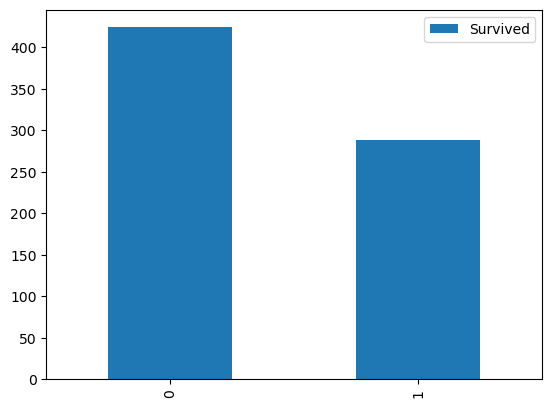

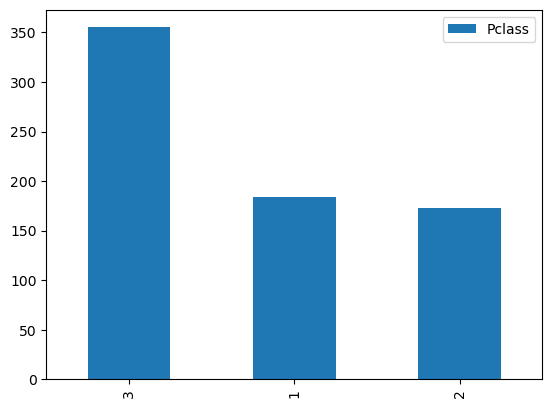

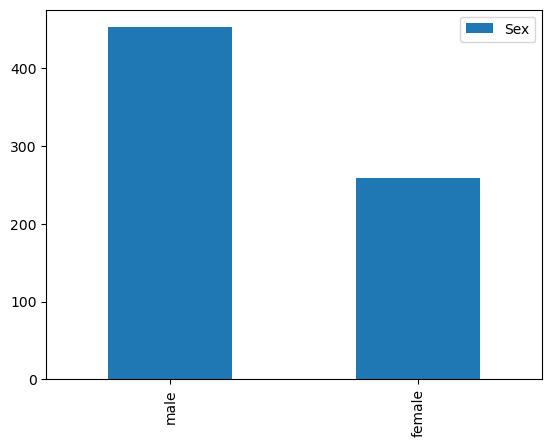

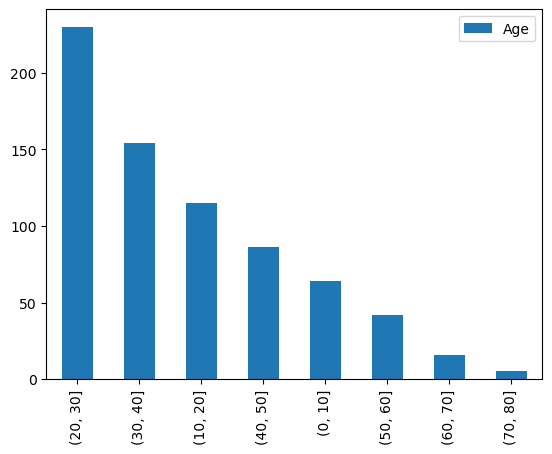

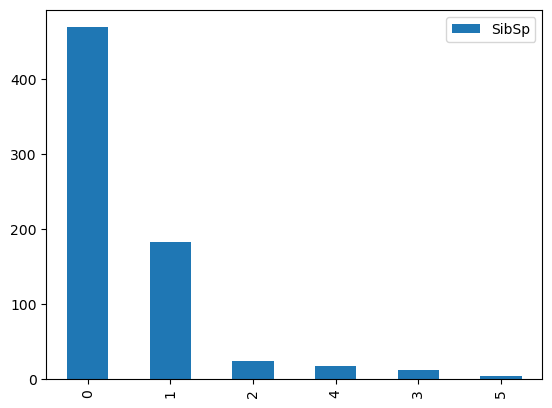

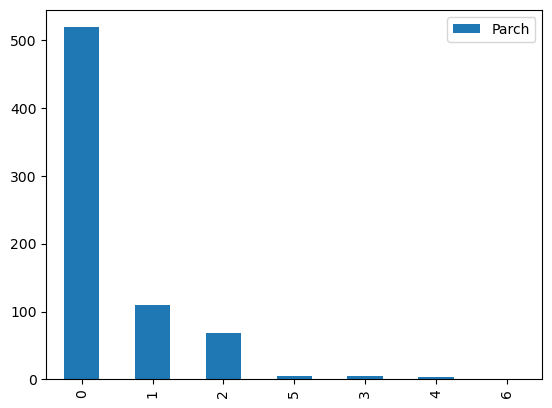

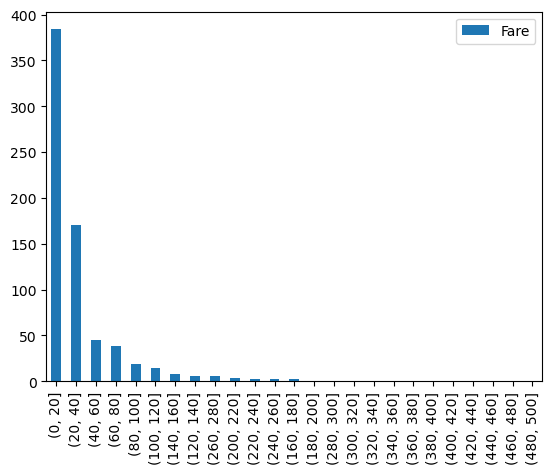

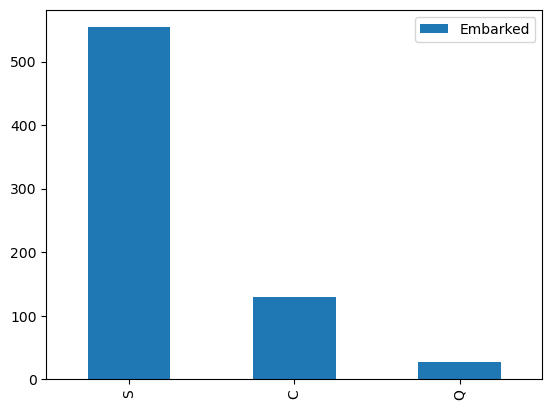

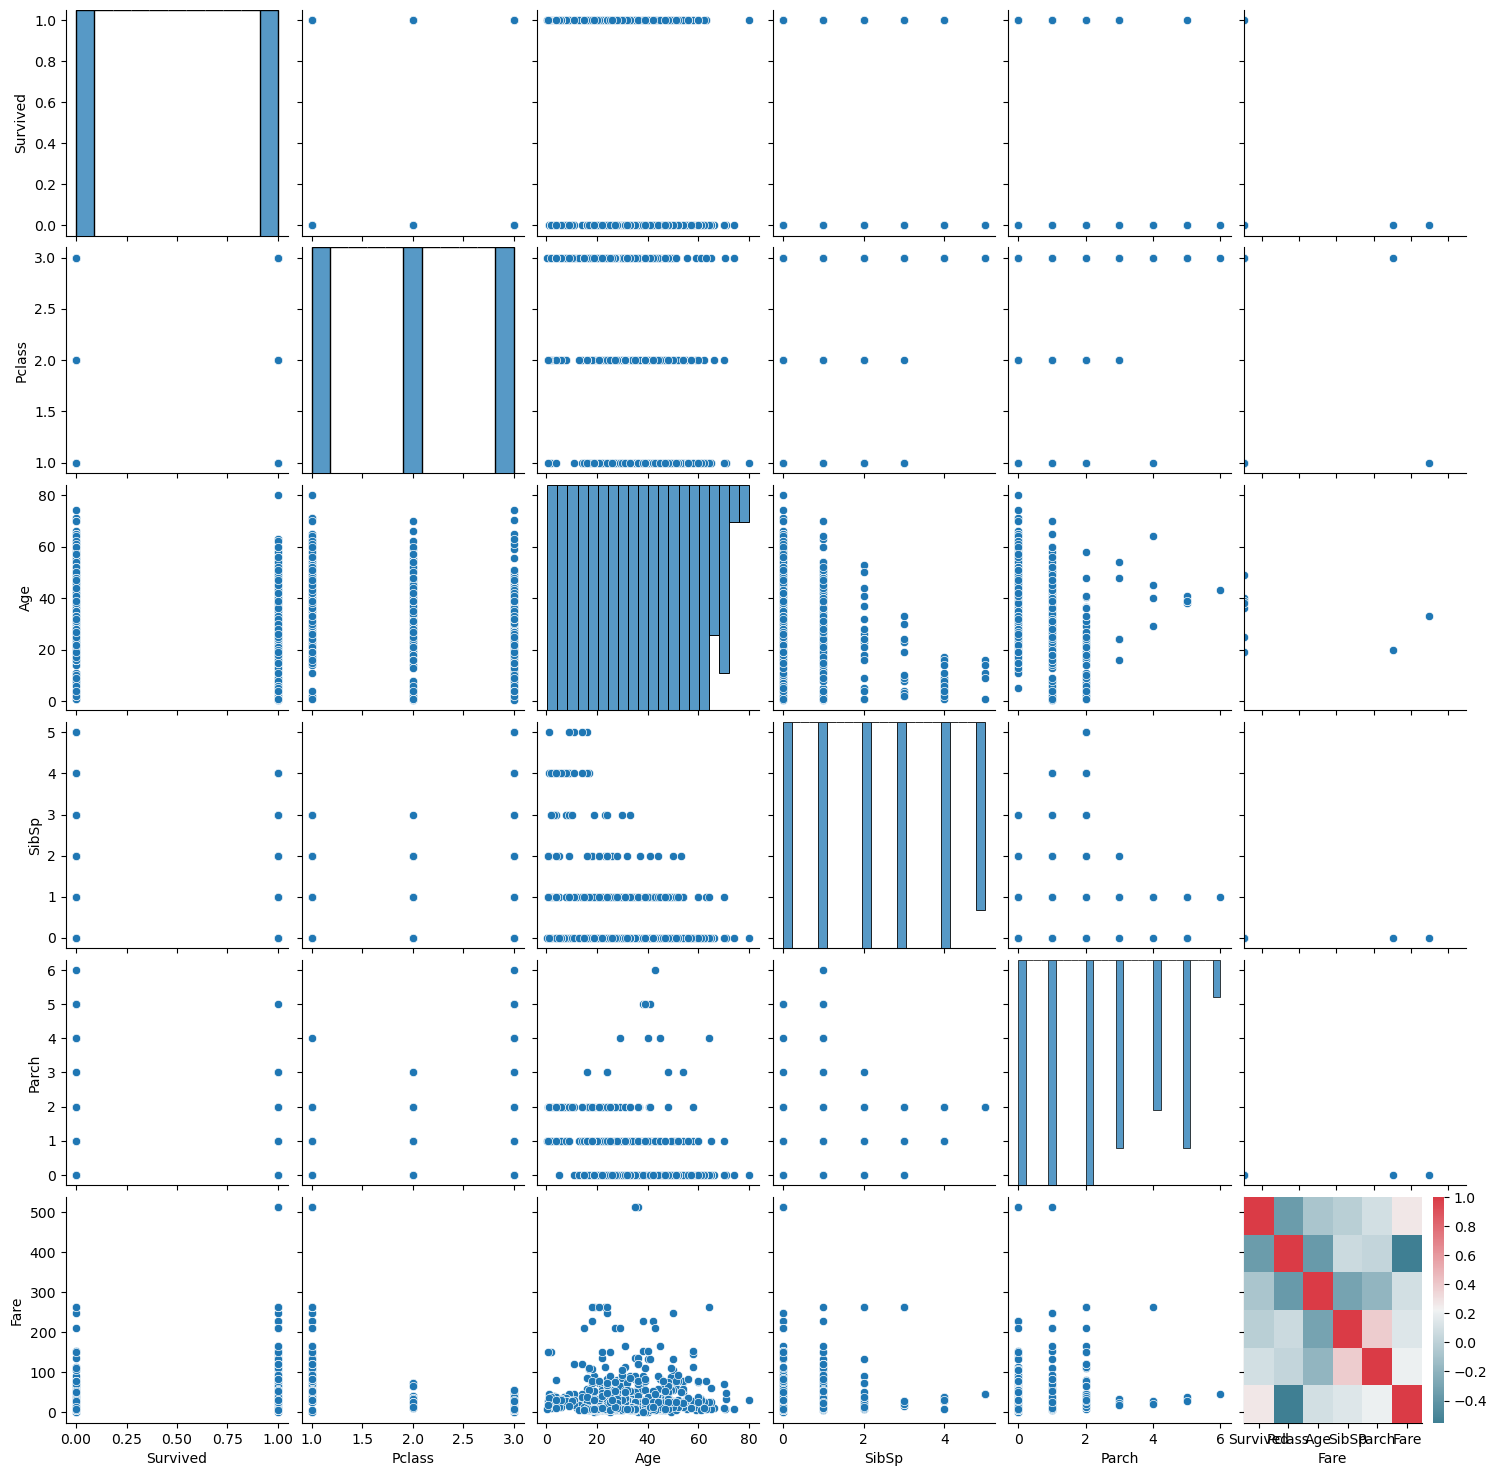

In [3]:
df = titanic.copy()
df['Age'] =pd.cut(df['Age'], range(0,90,10))
df['Fare'] =pd.cut(df['Fare'], range(0,520,20))
df.drop(columns=['Ticket'], inplace=True)
val_counts = []
for col in df.columns:
    tmp = pd.DataFrame(df[col].value_counts())
    if len(tmp) < len(titanic):
        val_counts.append(tmp)
        tmp.plot.bar()


sns.pairplot(titanic.loc[:,titanic.dtypes != 'object'])

corr = titanic.loc[:,titanic.dtypes != 'object'].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))


## Tuning Random Forest

In [4]:
num_cores = os.cpu_count()-1
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
RFparam_space= {
  'max_depth': max_depth,
  'max_features': ['sqrt', 'log2'],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10, 20],
  'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 7)]}

if not os.path.exists('TitanicOUT'):
   os.makedirs('TitanicOUT')
os.chdir('TitanicOUT')


rf = RandomForestClassifier()
TuneObj = Tuning(n_splits=10, repeat=5,  n_jobs=4)
RF = TuneObj.Tuning_RandomSearch_classify(X=X, Y=Y, repeat=1, n_splits=10, scorer='accuracy', mod=rf, hyperparameters=RFparam_space, n_iter=25, n_jobs=num_cores)
RF.to_csv('Titanic_RFrandSearch.txt', sep='\t')

Number of k-fold cross-validations run is: 1
Number of hyperparamter iterations tested is: 25
Function args: 'Tuning_RandomSearch_classify' executed in 33.3427s


## Random Search Analysis

{'n_estimators': [2000, 1700, 800], 'min_samples_split': [20, 5], 'min_samples_leaf': [1, 4, 2], 'max_features': ['log2', 'sqrt'], 'max_depth': [70, 50, 90]}


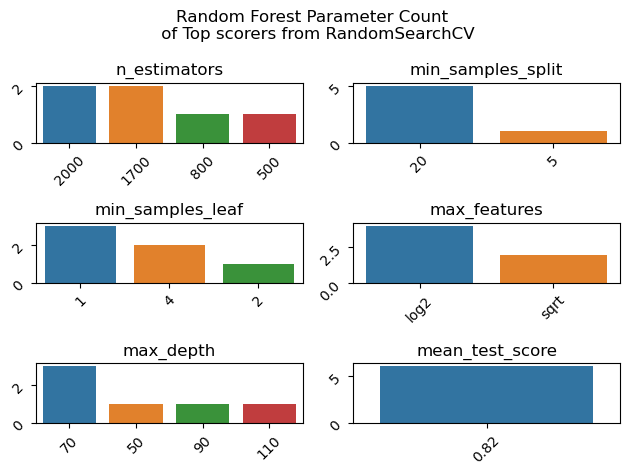

In [5]:
ParamFigObj = PMA.Param_analysis()
countData = ParamFigObj.RandomSearchAnalysis(RF, 0.25, 3, 'mean_test_score', figTitle='Random Forest Parameter Count \n of Top scorers from RandomSearchCV', figname="RandSearchFIG.png")
RFGridParamSpace = ParamFigObj.RandSearchParamGrid(countData, num_opt=3, outdir=os.getcwd(), outfile='RFGridParamSpace1.pickle')

In [6]:
TuneObj.repeat = 25
RF = TuneObj.Tuning_GridSearch_classify(X=X, Y=Y, repeat=TuneObj.repeat, n_splits=10, scorer='accuracy', mod=rf, hyperparameters=RFGridParamSpace, n_jobs=num_cores, stratify=True) #, n_jobs=numCores
RF.to_csv('RFgridSearch1.txt', sep='\t')

Number of repeats run is: 25
Function args: 'Tuning_GridSearch_classify' executed in 3812.6053s


## Grid Search Analysis

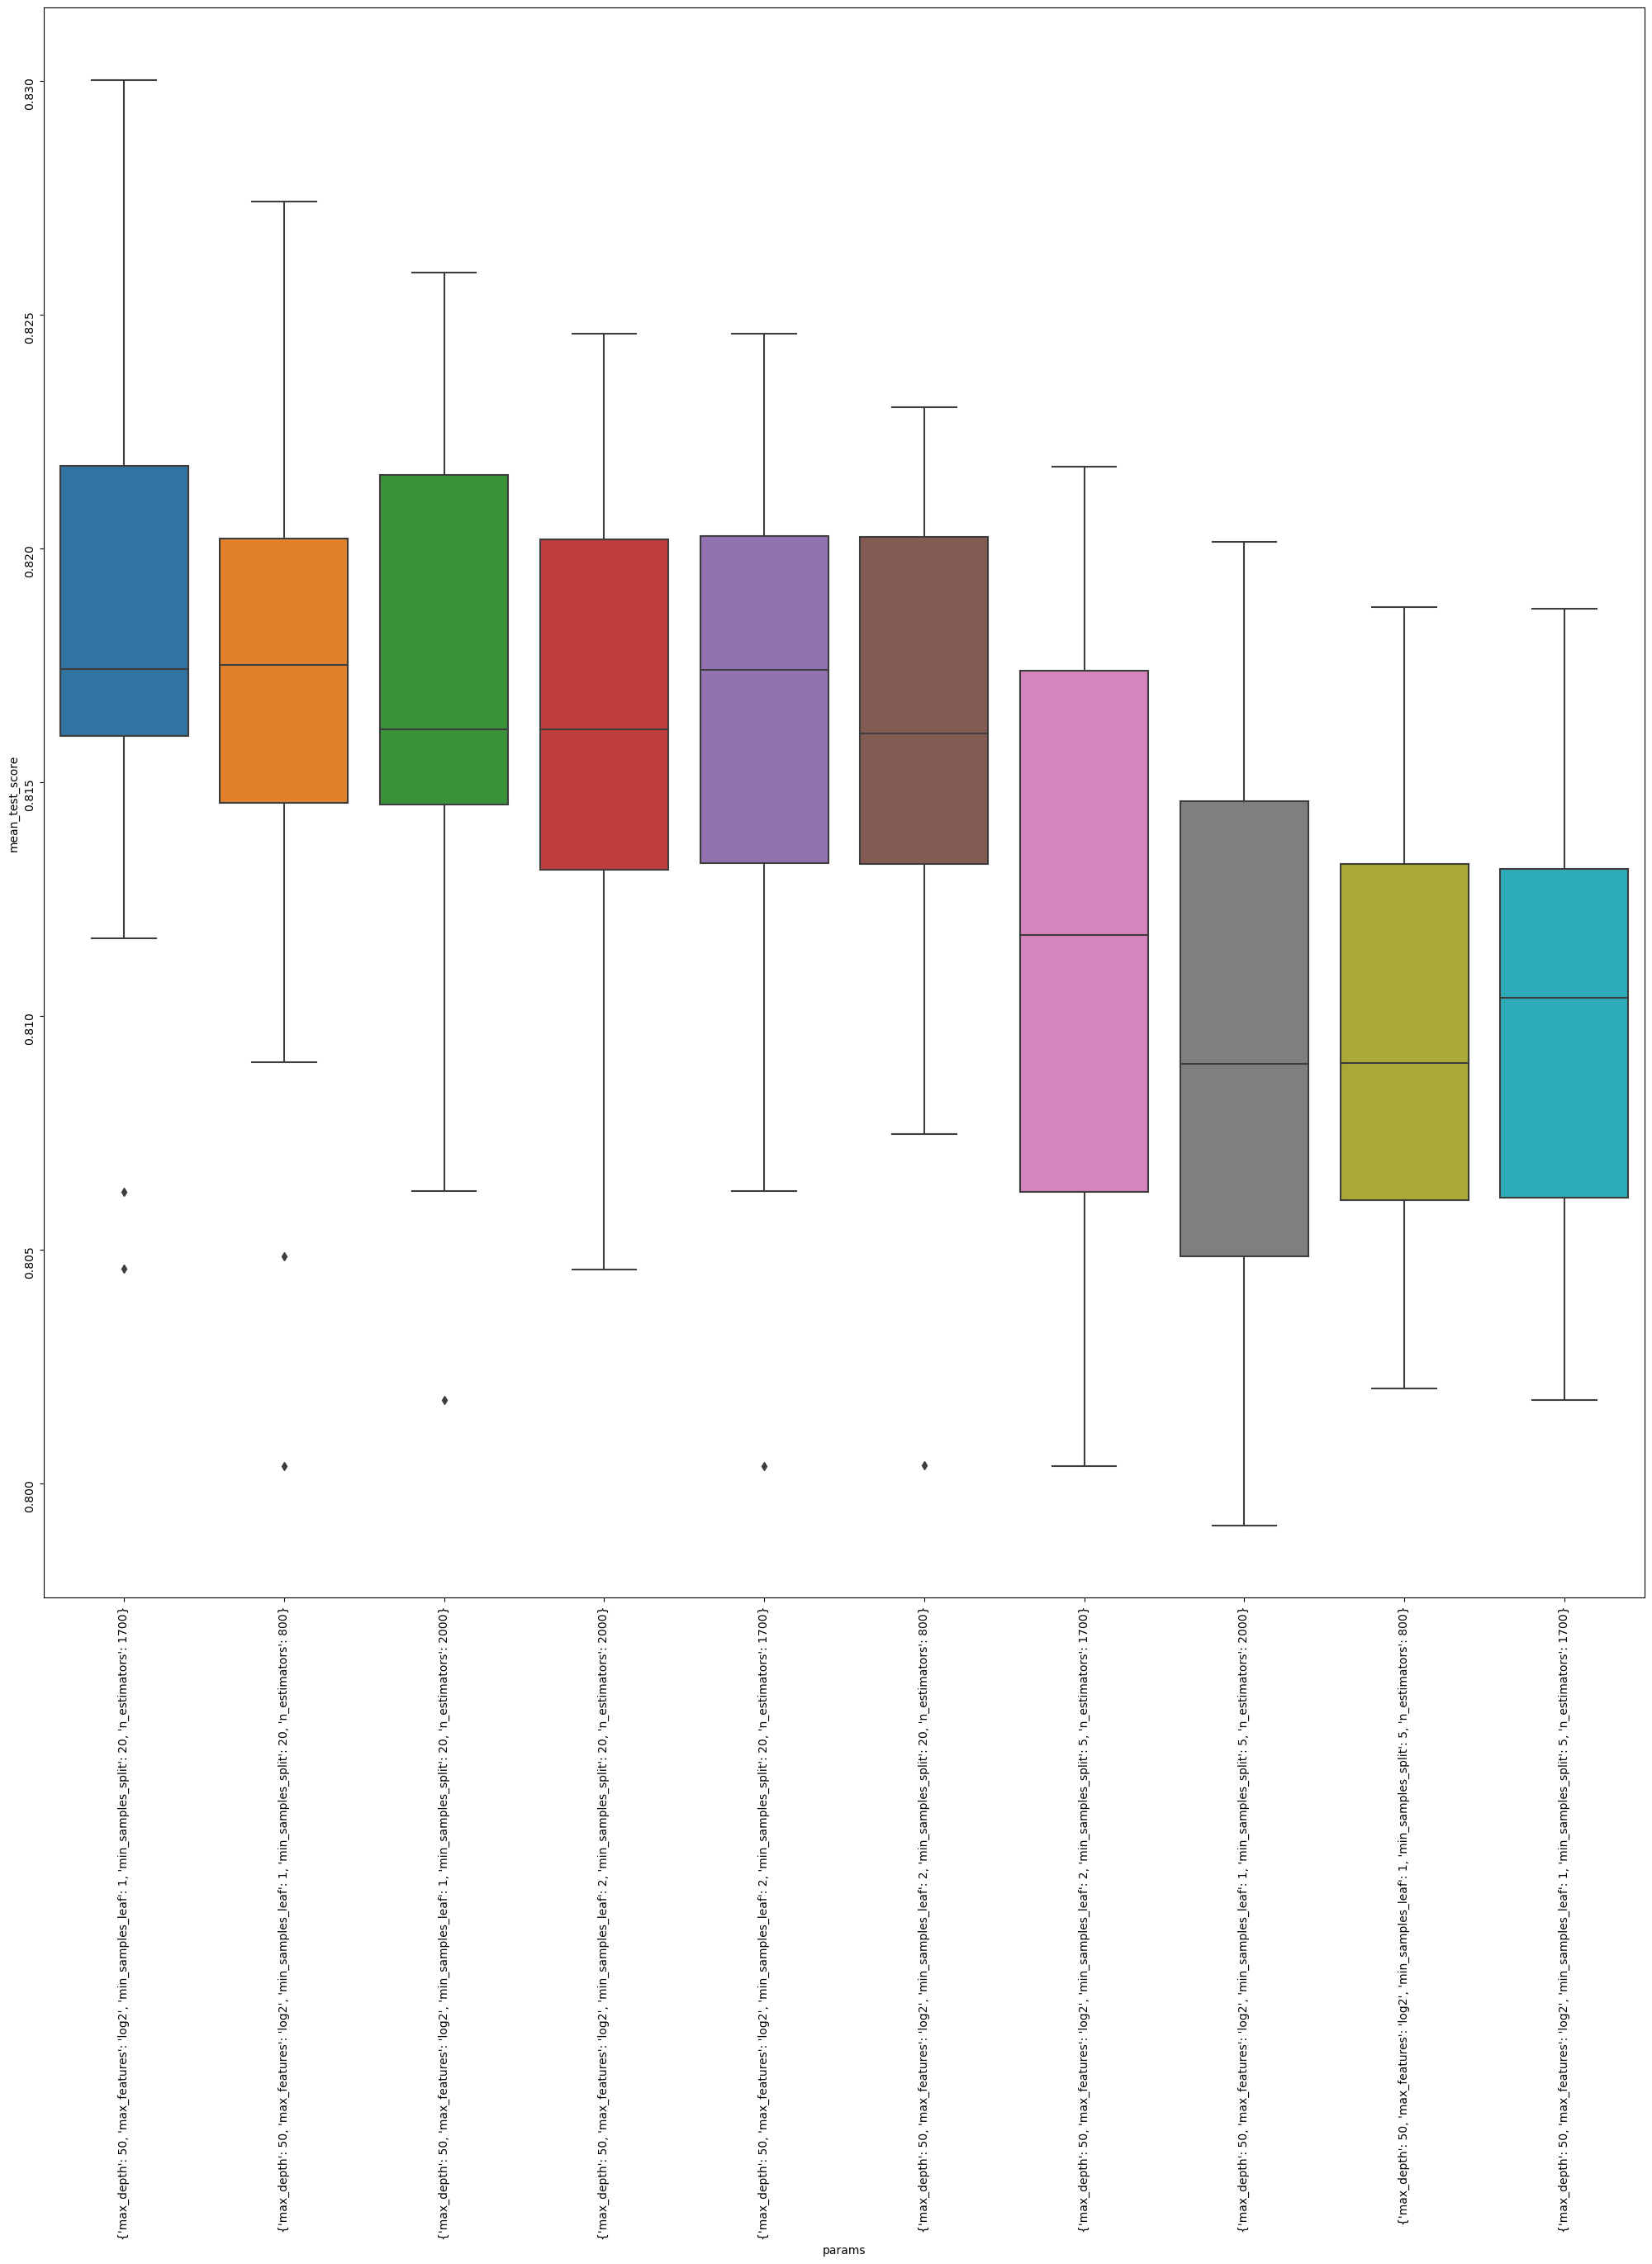

In [7]:

RF=pd.read_csv('RFgridSearch1.txt', sep='\t', index_col=0)
RF.sort_values('mean_test_score', ascending=False, inplace=True)
tmp=RF.groupby('params')['mean_test_score'].mean().reset_index()
RFbest = RF[RF['params'].isin(tmp.params.head(10).to_list())]
fig, ax = plt.subplots(figsize=(25, 25))
ax = sns.boxplot(data = RFbest, x='params', y='mean_test_score')
ax.tick_params(rotation=90)

## Define Best Performing RF hyperparameters.
* Perform k-fold corrected paired Ttest to identify statistically significant differences.
* If no statistically significant differences identified choose the most parsimonious model (following Occam's razor)

In [8]:
# ParamFigObj = PMA.Param_analysis()


# #### Plotting
# RF.params = RF.params.astype('str')
# RFbest = ParamFigObj.Best_mean(RF, 'mean_test_score', 10)
# RFTestFold =  ParamFigObj.Param_figs(RFbest, 'mean_test_score', 'LSBSR Random RF Tuning', 'param_max_depth', 'param_n_estimators') # Convert to seaborn
# RFTrainFold =  ParamFigObj.Param_figs(RFbest, 'mean_train_score', 'LSBSR Random RF Tuning', 'param_max_depth', 'param_n_estimators')
# RFTestFold.save('GridSearchFIG1_'+options.sim+'.png', dpi=300)


#### Define best params through repeated k-fold cross validation TTest
RFbest.reset_index(inplace=True)
groups = RFbest.groupby('params')
keys = groups.groups.keys()
r = TuneObj.repeat
k = TuneObj.n_splits
nsample =len(X)
n2 = int((1/k)*nsample*r)
n1 =int(((k-1)/k)*nsample*r)
ParamList=list(keys)
Comparables = list(combinations(ParamList,2))

BestLST = []
#### Find if there is statistacally significant difference

for i in range(len(Comparables)):
    t, pval = ParamFigObj.KfoldPairedTtest(r, k, n2, n1, groups.get_group(Comparables[i][0]), groups.get_group(Comparables[i][1]), 'mean_test_score', 'Phenotype')
    if pval <=0.05:
        BestLST.append(pval, Comparables[i][0], Comparables[i][1])
#### If no statistically significant difference, then use parsimony.
if len(BestLST)==0:
    RFbest.sort_values(['param_n_estimators', 'param_max_depth'], ascending=[False, False], inplace=True)
    # RFbest.params = RFbest.params.astype('str')
    RFbestParams = eval(RFbest.params[0])
    RFoptimal = RandomForestClassifier( **RFbestParams)

print(RFoptimal)
with open('RFOptimal_Tuning1.pickle', 'wb') as handle:
    pickle.dump(RFoptimal, handle, protocol=pickle.HIGHEST_PROTOCOL)

RandomForestClassifier(max_depth=50, max_features='log2', min_samples_split=20,
                       n_estimators=1700)


/var/folders/20/192vzyys2_b6v3q3tlh1tmd40000gn/T/ipykernel_95291/2262680340.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFbest.sort_values(['param_n_estimators', 'param_max_depth'], ascending=[False, False], inplace=True)
